In [ ]:
import pandas as pd
import glob
import os
import numpy as np
import hashlib
from rdkit import Chem

if os.path.exists("../data/raw_chembl_affinity.parquet"):
        full_df = pd.read_parquet("../data/raw_chembl_affinity.parquet")

else: 
    # Define input file pattern
    input_pattern = "../data/chembl_affinity/uniprot_*/*_chembl_activities.parquet"

    # Find all parquet files
    files = glob.glob(input_pattern)
    print(f"Found {len(files)} files.")

    # Load and concatenate
    dfs = []
    for f in files:
        try:
            df = pd.read_parquet(f)
            dfs.append(df)
        except Exception as e:
            print(f"Error reading {f}: {e}")

    if dfs:
        full_df = pd.concat(dfs, ignore_index=True)
        print(f"Total records loaded: {len(full_df)}")
        full_df.to_parquet("../data/chembl_affinity_raw.parquet", index=False)
    else:
        print("No data loaded.")
        full_df = pd.DataFrame()

full_df.head()

Found 1387 files.


/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_34255/1773798123.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat(dfs, ignore_index=True)


Total records loaded: 1237090


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,assay_tissue_chembl_id,assay_target_chembl_id,assay_document_chembl_id,assay_src_id,assay_src_assay_id,assay_category,assay_parameters,assay_classifications,assay_variant_sequence,source_uniprot_id
0,None,None,1442933,[],CHEMBL828168,In vitro inhibitory concentration against huma...,B,None,None,BAO_0000190,...,None,CHEMBL2828,CHEMBL1137167,1,None,None,None,None,None,P48730
1,None,None,1443232,[],CHEMBL828168,In vitro inhibitory concentration against huma...,B,None,None,BAO_0000190,...,None,CHEMBL2828,CHEMBL1137167,1,None,None,None,None,None,P48730
2,None,Not Determined,1443239,[],CHEMBL832320,In vitro inhibitory concentration against huma...,B,None,None,BAO_0000190,...,None,CHEMBL2828,CHEMBL1137167,1,None,None,None,None,None,P48730
3,None,None,1512981,[],CHEMBL833068,Inhibition of human casein kinase 1 delta at 1...,B,None,None,BAO_0000190,...,None,CHEMBL2828,CHEMBL1139545,1,None,None,None,None,None,P48730
4,None,None,1723122,[],CHEMBL860204,Inhibition of CK1delta,B,None,None,BAO_0000192,...,None,CHEMBL2828,CHEMBL1148638,1,None,None,None,None,None,P48730


In [2]:
full_df.to_parquet("../data/chembl_affinity_raw.parquet", index=False)

# Base Filtering

In [2]:
def apply_base_filters(df):
    print(f"Initial count: {len(df)}")
    
    # 1. Standard Type
    df = df[df['standard_type'].isin(['Ki', 'IC50'])]
    print(f"After Type filter: {len(df)}")
    
    # 2. Standard Units
    df = df[df['standard_units'] == 'nM']
    print(f"After Units filter: {len(df)}")
    
    # 3. Standard Relation
    df = df[df['standard_relation'] == '=']
    print(f"After Relation filter: {len(df)}")
    
    # 4. Data Validity
    df = df[df['data_validity_comment'].isnull()]
    print(f"After Validity filter: {len(df)}")
    
    # 5. Confidence Score
    # Note: assay_confidence_score might be numeric or string, checking both just in case or converting
    df['assay_confidence_score'] = pd.to_numeric(df['assay_confidence_score'], errors='coerce')
    df = df[df['assay_confidence_score'] == 9]
    print(f"After Confidence filter: {len(df)}")
    
    # 6. Only Docs (Document Year not null)
    df = df[df['document_year'].notnull()]
    print(f"After Docs filter: {len(df)}")
    
    # 7. Mutant Filtering
    # Check assay_description for keywords
    mutant_keywords = ['mutant', 'mutation', 'variant']
    # Ensure assay_description is string and handle NaNs
    mask = df['assay_description'].astype(str).str.lower().apply(lambda x: any(k in x for k in mutant_keywords))
    df = df[~mask]
    print(f"After Mutant filter: {len(df)}")
    
    return df

filtered_df = apply_base_filters(full_df)

Initial count: 1237090
After Type filter: 1051008
After Units filter: 983284
After Relation filter: 749185
After Validity filter: 733391
After Confidence filter: 420967
After Docs filter: 415109
After Mutant filter: 405562


# Assay Size Filtering

In [3]:
minAssaySize = 10 # Adjusted for small test dataset
maxAssaySize = 3000

# Count compounds per assay
assay_counts = filtered_df.groupby('assay_chembl_id').size()
print("Assay counts distribution:")
print(assay_counts.describe())
print("\nTop 5 assays by size:")
print(assay_counts.sort_values(ascending=False).head())

# Filter assays
valid_assays = assay_counts[(assay_counts >= minAssaySize) & (assay_counts <= maxAssaySize)].index
filtered_df = filtered_df[filtered_df['assay_chembl_id'].isin(valid_assays)]

print(f"After Assay Size filter: {len(filtered_df)} records from {len(valid_assays)} assays.")

Assay counts distribution:
count    40054.000000
mean        10.125381
std         27.471503
min          1.000000
25%          1.000000
50%          3.000000
75%         11.000000
max       1097.000000
dtype: float64

Top 5 assays by size:
assay_chembl_id
CHEMBL5738760    1097
CHEMBL5731107     978
CHEMBL3705123     752
CHEMBL3706373     745
CHEMBL3705362     729
dtype: int64
After Assay Size filter: 333748 records from 10865 assays.


## Savte the basic filtered 

In [4]:
if 'InchiKey' not in filtered_df.columns:
    filtered_df['InchiKey'] = filtered_df['canonical_smiles'].apply(
    lambda x: Chem.MolToInchiKey(Chem.MolFromSmiles(x)) if pd.notna(x) and Chem.MolFromSmiles(x) is not None else None
)
filtered_df = filtered_df[filtered_df['InchiKey'].notnull()]
filtered_df.to_parquet("../data/filtered_chembl_affinity.parquet", index=False)

## Save filtered data back to original UniProt directories

In [5]:
def save_filtered_to_uniprot_dirs(filtered_df, base_dir="../data/chembl_affinity"):
    """
    Save filtered data back to the original UniProt directories.
    Each UniProt's filtered data is saved alongside the raw parquet file.
    """
    # Check if source_uniprot_id column exists
    if 'source_uniprot_id' not in filtered_df.columns:
        print("Error: 'source_uniprot_id' column not found in filtered_df.")
        print("Available columns:", filtered_df.columns.tolist())
        return {}
    
    # Group by UniProt ID
    grouped = filtered_df.groupby('source_uniprot_id')
    
    save_stats = {
        'total_uniprots': 0,
        'saved': 0,
        'skipped_no_dir': 0,
        'records_saved': 0,
        'details': []
    }
    
    for uniprot_id, group_df in grouped:
        save_stats['total_uniprots'] += 1
        
        # Construct the target directory path
        uniprot_dir = os.path.join(base_dir, f"uniprot_{uniprot_id}")
        
        if not os.path.exists(uniprot_dir):
            save_stats['skipped_no_dir'] += 1
            continue
        
        # Save the filtered data
        output_filename = f"{uniprot_id}_chembl_activities_filtered.parquet"
        output_path = os.path.join(uniprot_dir, output_filename)
        
        try:
            group_df.to_parquet(output_path, index=False)
            save_stats['saved'] += 1
            save_stats['records_saved'] += len(group_df)
            save_stats['details'].append({
                'uniprot_id': uniprot_id,
                'records': len(group_df),
                'path': output_path
            })
        except Exception as e:
            print(f"Error saving {uniprot_id}: {e}")
    
    return save_stats

# Save filtered data to original UniProt directories
print("Saving filtered data to original UniProt directories...")
stats = save_filtered_to_uniprot_dirs(filtered_df)

print(f"\n=== Save Summary ===")
print(f"Total UniProt IDs in filtered data: {stats['total_uniprots']}")
print(f"Successfully saved: {stats['saved']}")
print(f"Skipped (directory not found): {stats['skipped_no_dir']}")
print(f"Total records saved: {stats['records_saved']:,}")

# Show sample of saved files
if stats['details']:
    print(f"\nSample of saved files (first 5):")
    for detail in stats['details'][:5]:
        print(f"  {detail['uniprot_id']}: {detail['records']:,} records")
    
    # Distribution of records per UniProt
    records_per_uniprot = [d['records'] for d in stats['details']]
    print(f"\nRecords per UniProt distribution:")
    print(f"  Min: {min(records_per_uniprot):,}")
    print(f"  Max: {max(records_per_uniprot):,}")
    print(f"  Mean: {np.mean(records_per_uniprot):,.1f}")
    print(f"  Median: {np.median(records_per_uniprot):,.1f}")

Saving filtered data to original UniProt directories...

=== Save Summary ===
Total UniProt IDs in filtered data: 837
Successfully saved: 837
Skipped (directory not found): 0
Total records saved: 333,611

Sample of saved files (first 5):
  O00141: 756 records
  O00206: 45 records
  O00238: 131 records
  O00255: 241 records
  O00311: 225 records

Records per UniProt distribution:
  Min: 10
  Max: 2,526
  Mean: 398.6
  Median: 200.0


In [6]:
# Quick validation: compare saved parquet files with aggregated filtered_df
def validate_saved_files(filtered_df, base_dir="../data/chembl_affinity", sample_size=5):
    """
    Validate that saved parquet files match the corresponding data in filtered_df.
    """
    if 'source_uniprot_id' not in filtered_df.columns:
        print("Error: 'source_uniprot_id' column not found.")
        return
    
    # Get list of UniProt IDs that should have been saved
    uniprot_ids = filtered_df['source_uniprot_id'].unique()
    
    # Sample a few for validation
    sample_ids = np.random.choice(uniprot_ids, min(sample_size, len(uniprot_ids)), replace=False)
    
    print(f"Validating {len(sample_ids)} randomly sampled UniProt files...\n")
    
    all_passed = True
    for uniprot_id in sample_ids:
        file_path = os.path.join(base_dir, f"uniprot_{uniprot_id}", f"{uniprot_id}_chembl_activities_filtered.parquet")
        
        if not os.path.exists(file_path):
            print(f"❌ {uniprot_id}: File not found at {file_path}")
            all_passed = False
            continue
        
        # Load saved file
        saved_df = pd.read_parquet(file_path)
        
        # Get expected data from filtered_df
        expected_df = filtered_df[filtered_df['source_uniprot_id'] == uniprot_id]
        
        # Compare record counts
        count_match = len(saved_df) == len(expected_df)
        
        # Compare columns
        cols_match = set(saved_df.columns) == set(expected_df.columns)
        
        # Compare a key column (InchiKey) to verify content
        saved_inchikeys = set(saved_df['InchiKey'].dropna())
        expected_inchikeys = set(expected_df['InchiKey'].dropna())
        content_match = saved_inchikeys == expected_inchikeys
        
        if count_match and cols_match and content_match:
            print(f"✅ {uniprot_id}: PASSED (records: {len(saved_df)}, columns: {len(saved_df.columns)})")
        else:
            all_passed = False
            print(f"❌ {uniprot_id}: FAILED")
            if not count_match:
                print(f"   - Record count mismatch: saved={len(saved_df)}, expected={len(expected_df)}")
            if not cols_match:
                print(f"   - Column mismatch: saved has {len(saved_df.columns)}, expected has {len(expected_df.columns)}")
            if not content_match:
                missing = expected_inchikeys - saved_inchikeys
                extra = saved_inchikeys - expected_inchikeys
                print(f"   - Content mismatch: {len(missing)} missing, {len(extra)} extra InchiKeys")
    
    print(f"\n{'='*40}")
    if all_passed:
        print("✅ All sampled files validated successfully!")
    else:
        print("⚠️ Some validations failed. Please check the output above.")
    
    # Also verify total record count across all saved files
    print(f"\n--- Aggregate Validation ---")
    total_saved = 0
    files_found = 0
    for uniprot_id in uniprot_ids:
        file_path = os.path.join(base_dir, f"uniprot_{uniprot_id}", f"{uniprot_id}_chembl_activities_filtered.parquet")
        if os.path.exists(file_path):
            saved_df = pd.read_parquet(file_path)
            total_saved += len(saved_df)
            files_found += 1
    
    print(f"Total records in filtered_df: {len(filtered_df):,}")
    print(f"Total records across {files_found} saved files: {total_saved:,}")
    print(f"Match: {'✅ Yes' if total_saved == len(filtered_df) else '❌ No (diff: ' + str(abs(total_saved - len(filtered_df))) + ')'}")

# Run validation
validate_saved_files(filtered_df)

Validating 5 randomly sampled UniProt files...

✅ Q08499: PASSED (records: 1283, columns: 73)
✅ P41279: PASSED (records: 136, columns: 73)
✅ P01111: PASSED (records: 46, columns: 73)
✅ P24530: PASSED (records: 130, columns: 73)
✅ P43403: PASSED (records: 152, columns: 73)

✅ All sampled files validated successfully!

--- Aggregate Validation ---
Total records in filtered_df: 333,611
Total records across 837 saved files: 333,611
Match: ✅ Yes


# Maxoverlap Filtering

In [7]:
def find_overlaps(group, max_match=True):
    # group is a dataframe for a specific target
    
    # Self merge on canonical_smiles
    # We only want pairs where assay_chembl_id_1 < assay_chembl_id_2 to avoid duplicates and self-matches
    merged = pd.merge(group, group, on='InchiKey', suffixes=('_1', '_2'))
    
    # Filter for different assays
    merged = merged[merged['assay_chembl_id_1'] < merged['assay_chembl_id_2']]
    
    if merged.empty:
        return pd.DataFrame()

    # 1. No Duplicate Docs (Different Documents)
    merged = merged[merged['document_chembl_id_1'] != merged['document_chembl_id_2']]
    
    # 2. Unit Error Correction (pChEMBL diff != 3.0)
    # Ensure pchembl_value is numeric
    merged['pchembl_value_1'] = pd.to_numeric(merged['pchembl_value_1'], errors='coerce')
    merged['pchembl_value_2'] = pd.to_numeric(merged['pchembl_value_2'], errors='coerce')
    
    merged = merged[abs(merged['pchembl_value_1'] - merged['pchembl_value_2']) != 3.0]
    
    # 3. Matching Assay Metadata (Max Curation)
    if max_match:
        metadata_cols = [
            'assay_organism_enriched', 
            'assay_tissue_enriched', 
            'assay_cell_type_enriched', 
            'assay_subcellular_fraction_enriched', 
            'assay_bao_format_enriched',
            # 'assay_variant_accession', 
            # 'assay_variant_mutation'
        ]
        
        # Check which columns actually exist in the dataframe
        existing_metadata_cols = [c for c in metadata_cols if c in group.columns]
        
        for col in existing_metadata_cols:
            # Handle NaNs: if both are NaN, they match. If one is NaN, they don't.
            merged = merged[merged[f'{col}_1'].fillna('MISSING') == merged[f'{col}_2'].fillna('MISSING')]
        
    return merged

# --- 1. Minimal Curation (Only Activity) ---
print("Running Minimal Curation (max_match=False)...")
overlap_results_min = []
for target, group in filtered_df.groupby('target_chembl_id'):
    overlaps = find_overlaps(group, max_match=False)
    if not overlaps.empty:
        overlap_results_min.append(overlaps)

if overlap_results_min:
    all_overlaps_min = pd.concat(overlap_results_min, ignore_index=True)
    print(f"Minimal Curation: Found {len(all_overlaps_min)} overlapping pairs.")
else:
    print("Minimal Curation: No overlaps found.")
    all_overlaps_min = pd.DataFrame()


# --- 2. Maximal Curation (With Metadata Matching) ---
print("\nRunning Maximal Curation (max_match=True)...")
overlap_results_max = []
for target, group in filtered_df.groupby('target_chembl_id'):
    overlaps = find_overlaps(group, max_match=True)
    if not overlaps.empty:
        overlap_results_max.append(overlaps)

if overlap_results_max:
    all_overlaps_max = pd.concat(overlap_results_max, ignore_index=True)
    print(f"Maximal Curation: Found {len(all_overlaps_max)} overlapping pairs.")
else:
    print("Maximal Curation: No overlaps found.")
    all_overlaps_max = pd.DataFrame()

Running Minimal Curation (max_match=False)...
Minimal Curation: Found 68495 overlapping pairs.

Running Maximal Curation (max_match=True)...
Maximal Curation: Found 48924 overlapping pairs.


In [8]:
all_overlaps_max[all_overlaps_max['pchembl_value_1']==all_overlaps_max['pchembl_value_2']][['pchembl_value_1', 'pchembl_value_2']]

,pchembl_value_1,pchembl_value_2
0,6.50,6.50
11,6.97,6.97
12,7.28,7.28
14,8.00,8.00
16,6.50,6.50
...,...,...
48919,7.18,7.18
48920,7.18,7.18
48921,7.18,7.18
48922,7.18,7.18


## save the minoverlap and maxoverlap entries 

In [9]:
# Save Minimal Curation Overlaps
if 'all_overlaps_min' in locals() and not all_overlaps_min.empty:
    # Remove duplicates based on the unique key of the overlap (Assay Pair + Compound)
    all_overlaps_min = all_overlaps_min.drop_duplicates(subset=['assay_chembl_id_1', 'assay_chembl_id_2', 'InchiKey'])
    
    output_path_min = "../data/minoverlap_chembl_affinity.parquet"
    all_overlaps_min.to_parquet(output_path_min, index=False)
    print(f"Saved minimal overlaps to {output_path_min} (Unique records: {len(all_overlaps_min)})")
else:
    print("No minimal overlaps to save.")

# Save Maximal Curation Overlaps
if 'all_overlaps_max' in locals() and not all_overlaps_max.empty:
    # Remove duplicates based on the unique key of the overlap (Assay Pair + Compound)
    all_overlaps_max = all_overlaps_max.drop_duplicates(subset=['assay_chembl_id_1', 'assay_chembl_id_2', 'InchiKey'])
    
    output_path_max = "../data/maxoverlap_chembl_affinity.parquet"
    all_overlaps_max.to_parquet(output_path_max, index=False)
    print(f"Saved maximal overlaps to {output_path_max} (Unique records: {len(all_overlaps_max)})")
else:
    print("No maximal overlaps to save.")

Saved minimal overlaps to ../data/minoverlap_chembl_affinity.parquet (Unique records: 63589)
Saved maximal overlaps to ../data/maxoverlap_chembl_affinity.parquet (Unique records: 45379)


# Visualization 

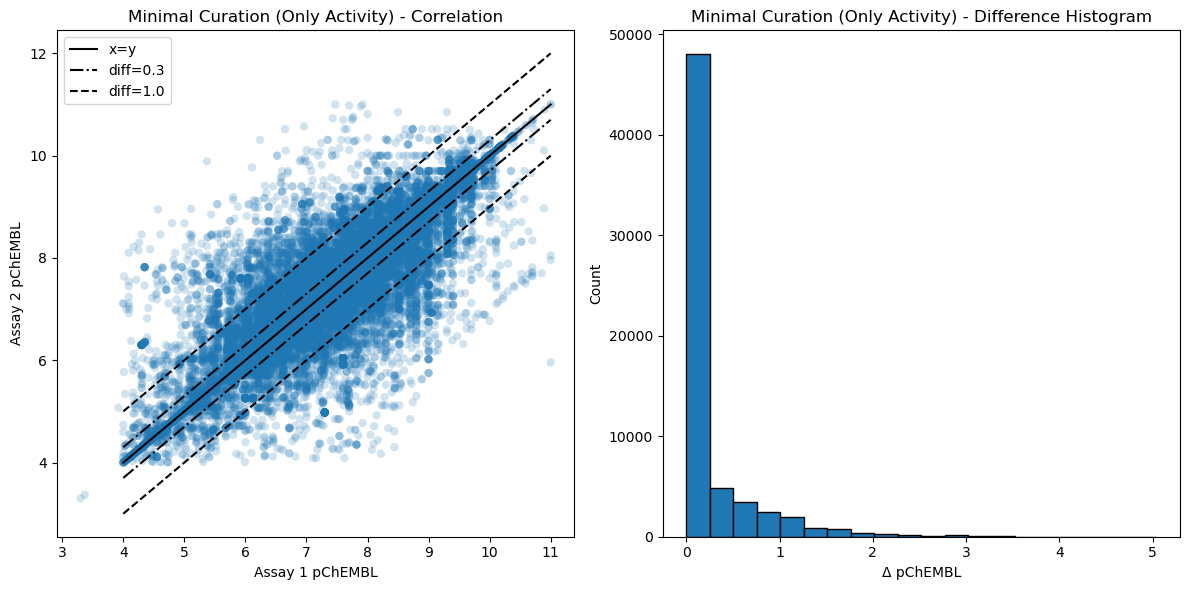

Statistics for Minimal Curation (Only Activity):
  Number of points: 63589
  R2: 0.80
  Spearman R: 0.90
  MAE: 0.00
  Points > 0.3: 14579 (22.93%)
  Points > 1.0: 4776 (7.51%)


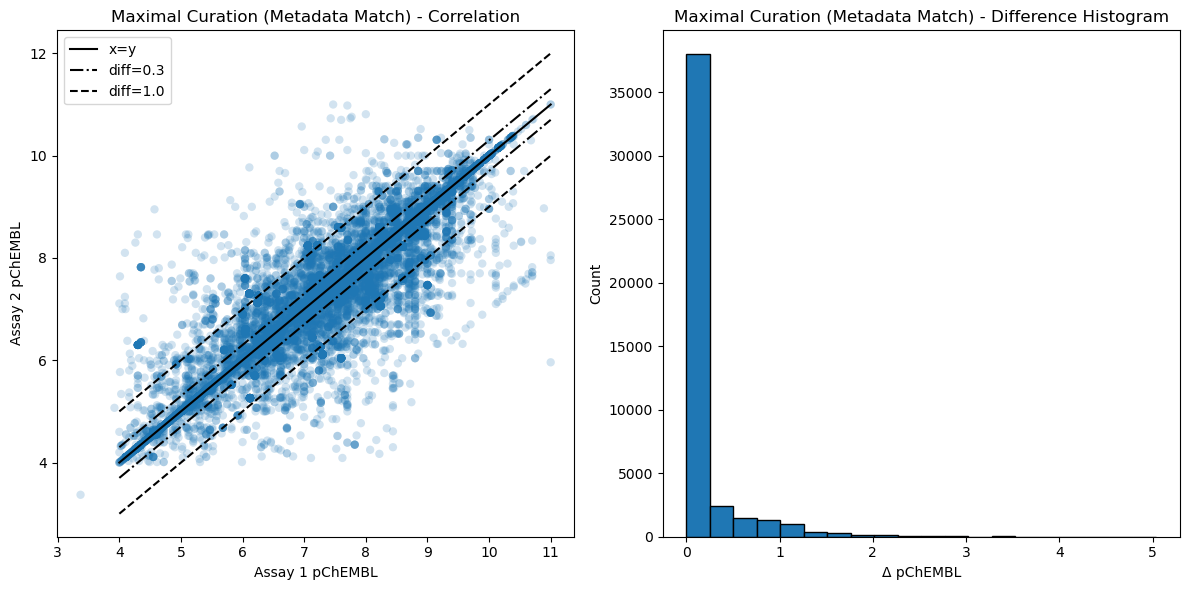

Statistics for Maximal Curation (Metadata Match):
  Number of points: 45379
  R2: 0.88
  Spearman R: 0.94
  MAE: 0.00
  Points > 0.3: 6979 (15.38%)
  Points > 1.0: 2193 (4.83%)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score, median_absolute_error

def plot_agreement(df, title):
    if df.empty:
        print(f"No data to plot for {title}.")
        return

    plt.figure(figsize=(12, 6))
    
    # Extract pChEMBL values
    xp = df['pchembl_value_1'].values
    yp = df['pchembl_value_2'].values
    
    # Left Plot: Correlation
    plt.subplot(1, 2, 1)
    plt.scatter(xp, yp, alpha=0.2, edgecolors='none')
    
    # Add reference lines
    line_min, line_max = 4, 11
    plt.plot((line_min, line_max), (line_min, line_max), 'k-', label='x=y') 
    plt.plot((line_min, line_max), (line_min - 0.3, line_max - 0.3), 'k-.', label='diff=0.3')
    plt.plot((line_min, line_max), (line_min + 0.3, line_max + 0.3), 'k-.')
    plt.plot((line_min, line_max), (line_min - 1.0, line_max - 1.0), 'k--', label='diff=1.0')
    plt.plot((line_min, line_max), (line_min + 1.0, line_max + 1.0), 'k--')
    
    plt.xlabel('Assay 1 pChEMBL')
    plt.ylabel('Assay 2 pChEMBL')
    plt.title(f'{title} - Correlation')
    plt.legend()
    
    # Right Plot: Histogram of differences
    plt.subplot(1, 2, 2)
    delts = np.abs(xp - yp)
    
    # Plot histogram
    n, bins, patches = plt.hist(delts, bins=20, edgecolor='black')
    plt.xlabel('Δ pChEMBL')
    plt.ylabel('Count')
    plt.title(f'{title} - Difference Histogram')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate Statistics
    r, p = stats.spearmanr(xp, yp)
    r2 = r2_score(xp, yp)
    mae = median_absolute_error(xp, yp)
    npts = len(delts)
    
    # Count points > 0.3 and > 1.0
    count_03 = np.sum(delts > 0.3)
    frac_03 = count_03 / npts
    
    count_10 = np.sum(delts > 1.0)
    frac_10 = count_10 / npts
    
    print(f"Statistics for {title}:")
    print(f"  Number of points: {npts}")
    print(f"  R2: {r2:.2f}")
    print(f"  Spearman R: {r:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  Points > 0.3: {count_03} ({frac_03:.2%})")
    print(f"  Points > 1.0: {count_10} ({frac_10:.2%})")

# Plot Minimal Curation
if 'all_overlaps_min' in locals():
    plot_agreement(all_overlaps_min, "Minimal Curation (Only Activity)")

# Plot Maximal Curation
if 'all_overlaps_max' in locals():
    plot_agreement(all_overlaps_max, "Maximal Curation (Metadata Match)")

## Visualize the distribution of assay sizes

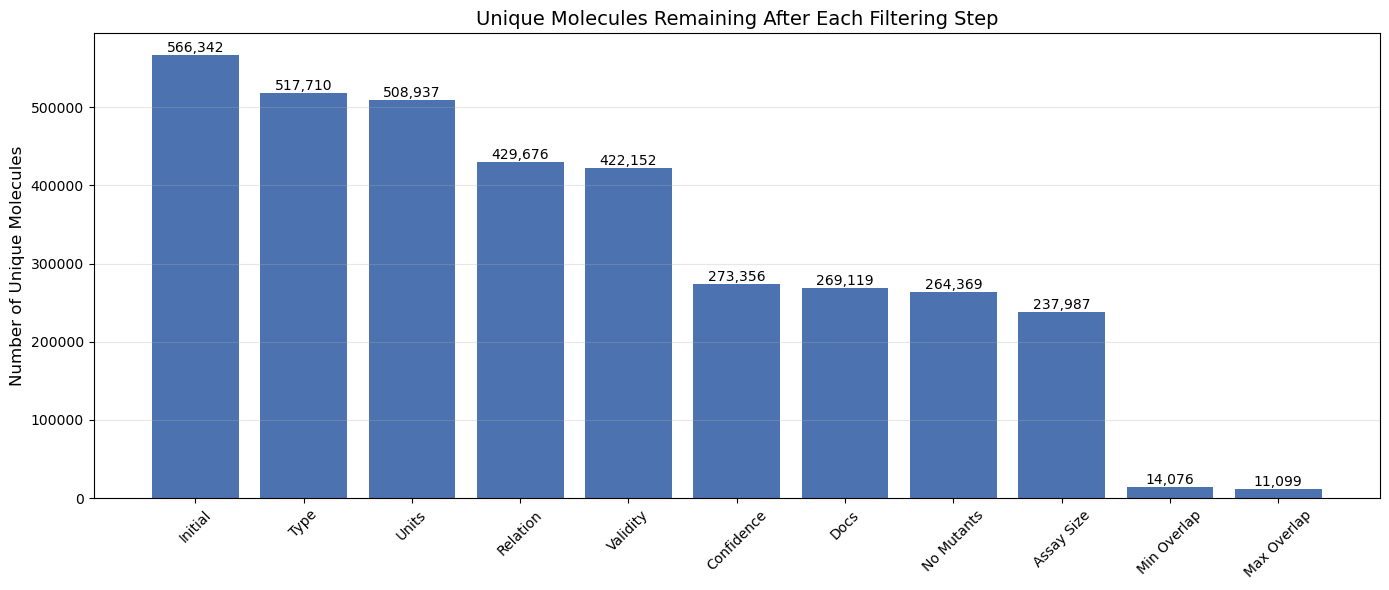

Step-by-step Molecule Counts:
Initial: 566,342 molecules
Type: 517,710 molecules
Units: 508,937 molecules
Relation: 429,676 molecules
Validity: 422,152 molecules
Confidence: 273,356 molecules
Docs: 269,119 molecules
No Mutants: 264,369 molecules
Assay Size: 237,987 molecules
Min Overlap: 14,076 molecules (from 63,589 overlapping pairs)
Max Overlap: 11,099 molecules (from 45,379 overlapping pairs)


In [11]:
# Visualize Molecule Counts after each step
import matplotlib.pyplot as plt
import pandas as pd

# Track counts and labels
step_counts = []
step_labels = []

# 1. Initial
current_df = full_df.copy()
step_counts.append(current_df['molecule_chembl_id'].nunique())
step_labels.append('Initial')

# 2. Base Filters (Broken down)
# Standard Type
current_df = current_df[current_df['standard_type'].isin(['Ki', 'IC50'])]
step_counts.append(current_df['molecule_chembl_id'].nunique())
step_labels.append('Type')

# Standard Units
current_df = current_df[current_df['standard_units'] == 'nM']
step_counts.append(current_df['molecule_chembl_id'].nunique())
step_labels.append('Units')

# Standard Relation
current_df = current_df[current_df['standard_relation'] == '=']
step_counts.append(current_df['molecule_chembl_id'].nunique())
step_labels.append('Relation')

# Data Validity
current_df = current_df[current_df['data_validity_comment'].isnull()]
step_counts.append(current_df['molecule_chembl_id'].nunique())
step_labels.append('Validity')

# Confidence Score
current_df['assay_confidence_score'] = pd.to_numeric(current_df['assay_confidence_score'], errors='coerce')
current_df = current_df[current_df['assay_confidence_score'] == 9]
step_counts.append(current_df['molecule_chembl_id'].nunique())
step_labels.append('Confidence')

# Only Docs
current_df = current_df[current_df['document_year'].notnull()]
step_counts.append(current_df['molecule_chembl_id'].nunique())
step_labels.append('Docs')

# Mutant Filtering
mutant_keywords = ['mutant', 'mutation', 'variant']
mask = current_df['assay_description'].astype(str).str.lower().apply(lambda x: any(k in x for k in mutant_keywords))
current_df = current_df[~mask]
step_counts.append(current_df['molecule_chembl_id'].nunique())
step_labels.append('No Mutants')

# 3. Assay Size Filters
# Re-apply assay size logic on the current_df
minAssaySize = 10
maxAssaySize = 3000
assay_counts = current_df.groupby('assay_chembl_id').size()
valid_assays = assay_counts[(assay_counts >= minAssaySize) & (assay_counts <= maxAssaySize)].index
current_df = current_df[current_df['assay_chembl_id'].isin(valid_assays)]

step_counts.append(current_df['molecule_chembl_id'].nunique())
step_labels.append('Assay Size')

# 4. Overlap Filters
# Check if overlap results exist in the global scope (from previous cells)
if 'all_overlaps_min' in locals() and isinstance(all_overlaps_min, pd.DataFrame) and not all_overlaps_min.empty:
    min_mols = all_overlaps_min['InchiKey'].nunique()
    step_counts.append(min_mols)
    step_labels.append('Min Overlap')

if 'all_overlaps_max' in locals() and isinstance(all_overlaps_max, pd.DataFrame) and not all_overlaps_max.empty:
    max_mols = all_overlaps_max['InchiKey'].nunique()
    step_counts.append(max_mols)
    step_labels.append('Max Overlap')

# Plotting
plt.figure(figsize=(14, 6))
bars = plt.bar(step_labels, step_counts, color='#4c72b0')

# Add counts on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=10, rotation=0)

plt.title('Unique Molecules Remaining After Each Filtering Step', fontsize=14)
plt.ylabel('Number of Unique Molecules', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary with Pair counts for overlaps
print("Step-by-step Molecule Counts:")
for label, count in zip(step_labels, step_counts):
    msg = f"{label}: {count:,} molecules"
    
    # Add pair info for overlap steps
    if label == 'Min Overlap' and 'all_overlaps_min' in locals():
        msg += f" (from {len(all_overlaps_min):,} overlapping pairs)"
    elif label == 'Max Overlap' and 'all_overlaps_max' in locals():
        msg += f" (from {len(all_overlaps_max):,} overlapping pairs)"
        
    print(msg)

## Visualize for Each Target

In [12]:
import os

def plot_agreement_per_target(df, target_id, save_path, title_suffix=""):
    if df.empty:
        return

    # Extract pChEMBL values
    xp = df['pchembl_value_1'].values
    yp = df['pchembl_value_2'].values
    
    plt.figure(figsize=(12, 5))
    
    # Left Plot: Correlation
    plt.subplot(1, 2, 1)
    plt.scatter(xp, yp, alpha=0.4, edgecolors='none')
    
    line_min, line_max = 4, 11
    plt.plot((line_min, line_max), (line_min, line_max), 'k-', label='x=y') 
    plt.plot((line_min, line_max), (line_min - 0.3, line_max - 0.3), 'k-.')
    plt.plot((line_min, line_max), (line_min + 0.3, line_max + 0.3), 'k-.')
    plt.plot((line_min, line_max), (line_min - 1.0, line_max - 1.0), 'k--')
    plt.plot((line_min, line_max), (line_min + 1.0, line_max + 1.0), 'k--')
    
    plt.xlabel('Assay 1 pChEMBL')
    plt.ylabel('Assay 2 pChEMBL')
    plt.title(f'Target {target_id} {title_suffix} - Correlation')
    
    # Right Plot: Histogram of differences
    plt.subplot(1, 2, 2)
    delts = np.abs(xp - yp)
    plt.hist(delts, bins=15, edgecolor='black')
    plt.xlabel('Δ pChEMBL')
    plt.ylabel('Count')
    plt.title(f'Target {target_id} {title_suffix} - Diff Hist')
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    
    # Print stats
    npts = len(delts)
    count_03 = np.sum(delts > 0.3)
    frac_03 = count_03 / npts
    print(f"Saved {title_suffix} plot to {save_path} (N={npts}, >0.3={frac_03:.2%})")

# Iterate through each target in the filtered dataframe
unique_targets = filtered_df['target_chembl_id'].unique()
print(f"Generating plots for {len(unique_targets)} targets...")

for target in unique_targets:
    target_group = filtered_df[filtered_df['target_chembl_id'] == target]
    
    # Determine save directory
    save_dir = f"data/output/plots/{target}" # Default
    if 'source_uniprot_id' in target_group.columns:
        uniprot_id = target_group['source_uniprot_id'].iloc[0]
        # Check if the original directory exists
        candidate_dir = f"data/chembl_parallel_enriched_part1/uniprot_{uniprot_id}"
        if os.path.exists(candidate_dir):
            save_dir = candidate_dir
    
    os.makedirs(save_dir, exist_ok=True)

    # 1. Minimal Curation Overlaps
    overlaps_min = find_overlaps(target_group, max_match=False)
    if not overlaps_min.empty:
        save_path = os.path.join(save_dir, f"{target}_agreement_minimal.png")
        plot_agreement_per_target(overlaps_min, target, save_path, "(Minimal)")
        
    # 2. Maximal Curation Overlaps
    overlaps_max = find_overlaps(target_group, max_match=True)
    if not overlaps_max.empty:
        save_path = os.path.join(save_dir, f"{target}_agreement_refined.png")
        plot_agreement_per_target(overlaps_max, target, save_path, "(Refined)")

Generating plots for 837 targets...
Saved (Minimal) plot to data/output/plots/CHEMBL2828/CHEMBL2828_agreement_minimal.png (N=1, >0.3=0.00%)
Saved (Minimal) plot to data/output/plots/CHEMBL4599/CHEMBL4599_agreement_minimal.png (N=44, >0.3=20.45%)
Saved (Refined) plot to data/output/plots/CHEMBL4599/CHEMBL4599_agreement_refined.png (N=44, >0.3=20.45%)
Saved (Minimal) plot to data/output/plots/CHEMBL5747/CHEMBL5747_agreement_minimal.png (N=30, >0.3=46.67%)
Saved (Refined) plot to data/output/plots/CHEMBL5747/CHEMBL5747_agreement_refined.png (N=26, >0.3=38.46%)
Saved (Minimal) plot to data/output/plots/CHEMBL5366/CHEMBL5366_agreement_minimal.png (N=120, >0.3=79.17%)
Saved (Refined) plot to data/output/plots/CHEMBL5366/CHEMBL5366_agreement_refined.png (N=37, >0.3=70.27%)
Saved (Minimal) plot to data/output/plots/CHEMBL2274/CHEMBL2274_agreement_minimal.png (N=15, >0.3=6.67%)
Saved (Refined) plot to data/output/plots/CHEMBL2274/CHEMBL2274_agreement_refined.png (N=15, >0.3=6.67%)
Saved (Minima